In [1]:
from langgraph.graph import START, END, StateGraph
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from typing import List, Annotated, TypedDict
from langchain.schema.runnable import RunnableConfig

from IPython.display import display, Image
from operator import add
load_dotenv()

True

In [2]:
model = ChatGroq(model = "meta-llama/llama-4-maverick-17b-128e-instruct",temperature=0)

In [3]:
class State(TypedDict):
    messages : Annotated[List[AnyMessage],add_messages]
    user_info: Annotated[list[str],add]
    
 
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""
    
def read_memory(state:State,config:RunnableConfig,store:BaseStore):
    user_id = config['configurable']["user_id"]
    namespace = ("memory",user_id)
    key = "user_memory"
    
    external_memory = store.get(namespace,key)
    if external_memory:
        memory_content = external_memory.value.get("memory")
    else:
        memory_content = None
        
    prompt_memory = MODEL_SYSTEM_MESSAGE.format(memory = memory_content)
    prompt_memory = SystemMessage(content = prompt_memory)
    
    message = model.invoke([prompt_memory]+state["messages"])
    
    return {"messages":message}
    

In [4]:
CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.
CURRENT USER INFORMATION (Intially this may be empty):  
{memory} 

INSTRUCTIONS:
1. Review the chat history below carefully
2. Extract information about user from it

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.
Just update do not remove the previous accumulated info about user
"""

def write_memory(state:State, config:RunnableConfig ,store:BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memory",user_id)
    key = "user_memory"
    
    existing_memory = store.get(namespace,key)
    if existing_memory:
        memory_content = existing_memory.value.get("memory")
    else:
        memory_content = None
        
    prompt = CREATE_MEMORY_INSTRUCTION.format(memory = memory_content)
    new_memory = model.invoke([SystemMessage(content=prompt)]+state['messages'])
    
    store.put(namespace,key,value={"memory":new_memory.content})
    return {"user_info": [new_memory.content]}

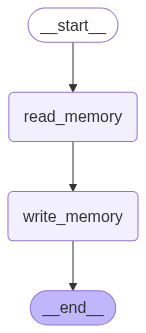

In [5]:
builder = StateGraph(State)
memory = MemorySaver()
store = InMemoryStore()
config = {"configurable":{"thread_id":"1","user_id":"1"}}

builder.add_node("read_memory",read_memory)
builder.add_node("write_memory",write_memory)

builder.add_edge(START,"read_memory")
builder.add_edge("read_memory","write_memory")
builder.add_edge("write_memory",END)

graph = builder.compile(checkpointer=memory,store=store)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable":{"thread_id":"1","user_id":"1"}}

for chunk in graph.stream({"messages":[HumanMessage("My name is Manas,I like pizza.")]},config=config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

My name is Manas,I like pizza.
================================== Ai Message ==================================

Nice to meet you, Manas! I'll make sure to remember that you're a pizza fan. I'll store this information for future conversations. So, what's your favorite type of pizza, Manas?
================================== Ai Message ==================================

Nice to meet you, Manas! I'll make sure to remember that you're a pizza fan. I'll store this information for future conversations. So, what's your favorite type of pizza, Manas?


In [7]:
thread = {"configurable": {"thread_id": "1","user_id":"1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

My name is Manas,I like pizza.
================================== Ai Message ==================================

Nice to meet you, Manas! I'll make sure to remember that you're a pizza fan. I'll store this information for future conversations. So, what's your favorite type of pizza, Manas?


In [8]:
for chunk in graph.stream({"messages":[HumanMessage("I live in Gachibowli, Hyderabad. From the above filter out the ones that are 5 km away from me. Also give the address of each outlet near me")]},config=config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

I live in Gachibowli, Hyderabad. From the above filter out the ones that are 5 km away from me. Also give the address of each outlet near me
================================== Ai Message ==================================

I'm happy to help you, Manas. However, I don't have real-time information about pizza outlets in Gachibowli, Hyderabad. But I can guide you on how to find the information you're looking for.

To find pizza outlets within 5 km of your location, you can use online directories like Google Maps or food delivery apps like Swiggy or Zomato. Here's how:

1. Open Google Maps or a food delivery app on your device.
2. Enter "pizza outlets near me" or "pizza places in Gachibowli" in the search bar.
3. The app will show you a list of nearby pizza outlets along with their addresses and distances from your location.
4. Filter the results to show only outlets within 5 km of your location.

Some popula

In [9]:
config = {"configurable":{"thread_id":'2',"user_id":"1"}}

for chunk in graph.stream({"messages":"Do you know what I like"},config=config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Do you know what I like
================================== Ai Message ==================================

You like Pizza, don't you? I remember that about you, Manas.
================================== Ai Message ==================================

You like Pizza, don't you? I remember that about you, Manas.


In [10]:
config = {"configurable":{"thread_id":"2","user_id":"1"}}

for chunk in graph.stream({"messages":"Do you know where I live"},config=config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Do you know where I live
================================== Ai Message ==================================

You live in Gachibowli, if I'm not mistaken. You mentioned it before, and I recall that you were asking me how life was treating you there.
================================== Ai Message ==================================

You live in Gachibowli, if I'm not mistaken. You mentioned it before, and I recall that you were asking me how life was treating you there.


In [ ]:
config = {"configurable":{"thread_id":"3","user_id":"1"}}

for chunk in graph.stream({"messages":"Do you know where I live"},config=config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

In [11]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = store.get(namespace, "user_memory")
existing_memory

Item(namespace=['memory', '1'], key='user_memory', value={'memory': ''}, created_at='2025-07-06T20:23:21.438702+00:00', updated_at='2025-07-06T20:23:21.438719+00:00')

In [12]:
graph.get_state(config={"configurable": {"thread_id": "1","user_id":"1"}}).values['user_info']

[" \n\nHere's the information I've gathered about you so far:\n- Name: Manas\n- Likes: Pizza",
 " \n\nBy the way, I've updated the information about you:\n- Name: Manas\n- Likes: Pizza \n- Lives in: Gachibowli, Hyderabad"]

In [14]:
from typing import TypedDict, List
class UserProfile(TypedDict):
    name:str
    interests:List[str]

In [15]:
user_profile = UserProfile(
    name = "Manas",
    interests = ["Data Science","Machine Learning","NLP","Computer Vision","Robotics","Product Management"]
)

In [17]:
user_profile

{'name': 'Manas',
 'interests': ['Data Science',
  'Machine Learning',
  'NLP',
  'Computer Vision',
  'Robotics',
  'Product Management']}

In [18]:
from langgraph.store.memory import InMemoryStore
import uuid

user_id = str(uuid.uuid4())

store = InMemoryStore()
namespace = ("user_id",user_id)
key = "user_profile"

store.put(namespace,key,value=user_profile)

In [20]:
existing_memory = store.get(namespace,key).value
existing_memory

{'name': 'Manas',
 'interests': ['Data Science',
  'Machine Learning',
  'NLP',
  'Computer Vision',
  'Robotics',
  'Product Management']}

In [21]:
from pydantic import BaseModel, Field
class UserProfile(BaseModel):
    name:str = Field(description="name of the user")
    interests:List[str] = Field(description="interests of the user")

In [22]:
model = ChatGroq(model = "llama-3.1-8b-instant")
structured_llm = model.with_structured_output(schema=UserProfile)
result = structured_llm.invoke(input = [HumanMessage(content="I am Manas Agarwal. I like to dance, go to GYM, cook great food, eat great food")])
result

UserProfile(name='Manas Agarwal', interests=['dancing', 'going to the gym', 'cooking great food', 'eating great food'])

In [25]:
dict_result = result.model_dump()
dict_result

{'name': 'Manas Agarwal',
 'interests': ['dancing',
  'going to the gym',
  'cooking great food',
  'eating great food']}

In [27]:
mem_store = InMemoryStore()
mem_store.put(namespace,key,dict_result)
existing_memory = mem_store.get(namespace,key)
existing_memory.value

{'name': 'Manas Agarwal',
 'interests': ['dancing',
  'going to the gym',
  'cooking great food',
  'eating great food']}

In [28]:
from langgraph.graph import START, END, StateGraph
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from typing import List, Annotated, TypedDict
from langchain.schema.runnable import RunnableConfig

from IPython.display import display, Image
from operator import add
load_dotenv()

True

In [29]:
class State(TypedDict):
    messages:Annotated[List[AnyMessage],add_messages]

In [31]:
from pydantic import BaseModel, Field

class UserProfile(BaseModel):
    name:str = Field(description="name of the user")
    interests:List[str] = Field(description="interests of the user")

In [30]:
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

def read_memory(state:State,config:RunnableConfig,store:BaseStore):
    
    namespace = ("user_memory",user_id)
    key = "user_profile"
    
    existing_memory = store.get(namespace,key)
    if existing_memory and existing_memory.value:
        formatted_memory = (
            f"Name: {existing_memory.value.get('name','Unknown')}\n"
            f"Interests: {", ".join(existing_memory.value.get('interests',[]))}"
        )
    else:
        formatted_memory = None
        
    formatted_prompt = MODEL_SYSTEM_MESSAGE.format(memory = formatted_memory)
    response = model.invoke([SystemMessage(content=formatted_prompt)]+state['messages'])
    return {"messages":response}
    

In [32]:
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def write_memory(state:State,config:RunnableConfig,store:BaseStore):
    
    namespace = ("user_memory",user_id)
    key = "user_profile"
    
    existing_memory = store.get(namespace,key)
    if existing_memory and existing_memory.value:
        formatted_memory = (
            f"Name: {existing_memory.value.get('name','Unknown')}\n"
            f"Interests: {", ".join(existing_memory.value.get('interests',[]))}"
        )
    else:
        formatted_memory = None
    
    formatted_prompt = CREATE_MEMORY_INSTRUCTION.format(memory = formatted_memory)
    structured_llm = model.with_structured_output(schema=UserProfile)    
    response = structured_llm.invoke([SystemMessage(content=formatted_prompt)]+state['messages'])
    store.put(namespace,key,response.model_dump())

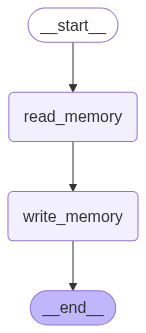

In [ ]:
builder = StateGraph(State)
memory = MemorySaver()
store = InMemoryStore()

builder.add_node("read_memory",read_memory)
builder.add_node("write_memory",write_memory)

builder.add_edge(START,"read_memory")
builder.add_edge("read_memory","write_memory")
builder.add_edge("write_memory",END)

graph = builder.compile(checkpointer=memory,store=store)
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
config = {"configurable":{"thread_id":"first","user_id":"1"}}
for chunk in graph.stream({"messages":"Hi I am Manas. I like dancing and swimming"},config=config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Hi I am Manas. I like dancing and swimming
================================== Ai Message ==================================

Nice to meet you, Manas. I'm glad to learn that you enjoy dancing and swimming. I'll make a note of this for our conversation history. 

So, which type of dance do you enjoy the most - classical, contemporary, or something else? And do you have a favorite swimming stroke or a favorite pool to swim in?


In [38]:
namespace = ("user_memory",user_id)
key = "user_profile"
mem = store.get(namespace,key)
mem.value

{'name': 'Manas', 'interests': ['dancing', 'swimming', 'healthy eating']}

In [37]:
config = {"configurable":{"thread_id":"first","user_id":"1"}}
for chunk in graph.stream({"messages":"After swimming I like to eat healthy salad"},config=config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

After swimming I like to eat healthy salad
================================== Ai Message ==================================

It's great that you enjoy eating healthy after your swim, Manas. Salads are a fantastic choice, and they're perfect for refueling after a workout like swimming. 

I'm glad I was able to remember that you enjoy swimming, and now I know that you also prioritize healthy eating. Do you have a go-to place to get your favorite salads or do you like making them at home?


In [ ]:
config = {"configurable":{"thread_id":"third","user_id":"1"}}

for chunk in graph.stream({"messages":"what is my name and what are interests"},config=config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is my name and what are interests
================================== Ai Message ==================================

Nice to assist you, Manas. 

You are Manas, and your interests include:

1. Dancing
2. Swimming
3. Healthy eating

I'll keep these in mind as we chat. How can I help you today?
